In [1]:
%%html
<!-- Potrzebne dla poprawnego wyświetlania tqdm w VSCode https://stackoverflow.com/a/77566731 -->
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}
</style>

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch

torch.backends.cudnn.benchmark = True


In [3]:
def get_device():
  return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device = get_device()
device

device(type='cuda')

## Wczytywanie zbioru danych

In [4]:
import torch

from torchvision.transforms import InterpolationMode
import torchvision.transforms.v2 as v2

from A2D2Dataset import A2D2Dataset
from torchvision.datasets import Cityscapes

# transformacje
transforms = v2.Compose([
    v2.RandomResizedCrop((768, 768), scale=(0.5, 2.0), interpolation=InterpolationMode.NEAREST),
    v2.RandomHorizontalFlip(0.5),
    v2.PILToTensor(),
    v2.ConvertImageDtype(torch.float32),
    v2.ColorJitter(0.2, 0.2, 0.2, 0.1),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# A2D2

a2d2_root = ".\\data\\a2d2\\"

train_dataset = A2D2Dataset(
    root=a2d2_root,
    split='train',
    transforms=transforms
    
)

test_dataset = A2D2Dataset(
    root=a2d2_root,
    split='val',
    transforms=transforms
)

# Cityscapes

# cityscapes_root = ".\\data\\cityscapes"

# train_dataset = Cityscapes(
#     root=cityscapes_root,
#     split='train',
#     target_type="semantic",
#     transforms=transforms
# )

# test_dataset = Cityscapes(
#     root=cityscapes_root,
#     split='val',
#     target_type="semantic",
#     transforms=transforms
# )

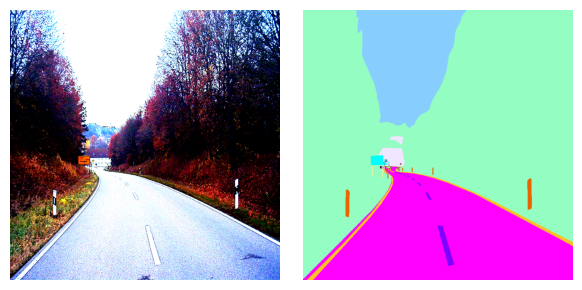

In [5]:
from A2D2Dataset import A2D2Dataset
from torchvision.datasets import cityscapes
import matplotlib.pyplot as plt
import numpy as np

image, label = test_dataset[1]

fig, ax = plt.subplots(1, 2, figsize=(6, 3))

img_np = np.clip(image.permute(1,2,0).numpy(), 0, 1)
img_np = np.clip(img_np, 0, 1)

mask_np = label.squeeze(0).numpy()

palette = {
    cls.id: cls.color
    for cls in test_dataset.classes
    if getattr(cls, "train_id", 0) != 255
}

mask_rgb = np.zeros((*mask_np.shape, 3), dtype=np.uint8)
for cid, rgb in palette.items():
    mask_rgb[mask_np == cid] = rgb

plt.subplot(1, 2, 1); plt.imshow(img_np);   plt.axis('off')
plt.subplot(1, 2, 2); plt.imshow(mask_rgb); plt.axis('off')
plt.tight_layout(); plt.show()

In [ ]:
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights

from train import train_model

weights = DeepLabV3_ResNet50_Weights.DEFAULT
model = deeplabv3_resnet50(weights=weights, aux_loss=True)

train_model(
    model=model,
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    ckpt_name="resnet50_a2d2",
    device=device
)

Loading checkpoint 'resnet50_a2d2'
Resuming from epoch 1


  0%|          | 0/5007 [00:00<?, ?it/s]

## Generowanie przykładowych obrazów
Po wytrenowaniu modelu należy wprowadzić poniżej nazwę checkpointu oraz ścieżkę do pliku `.png`, na  którym można przetestować działanie modelu.

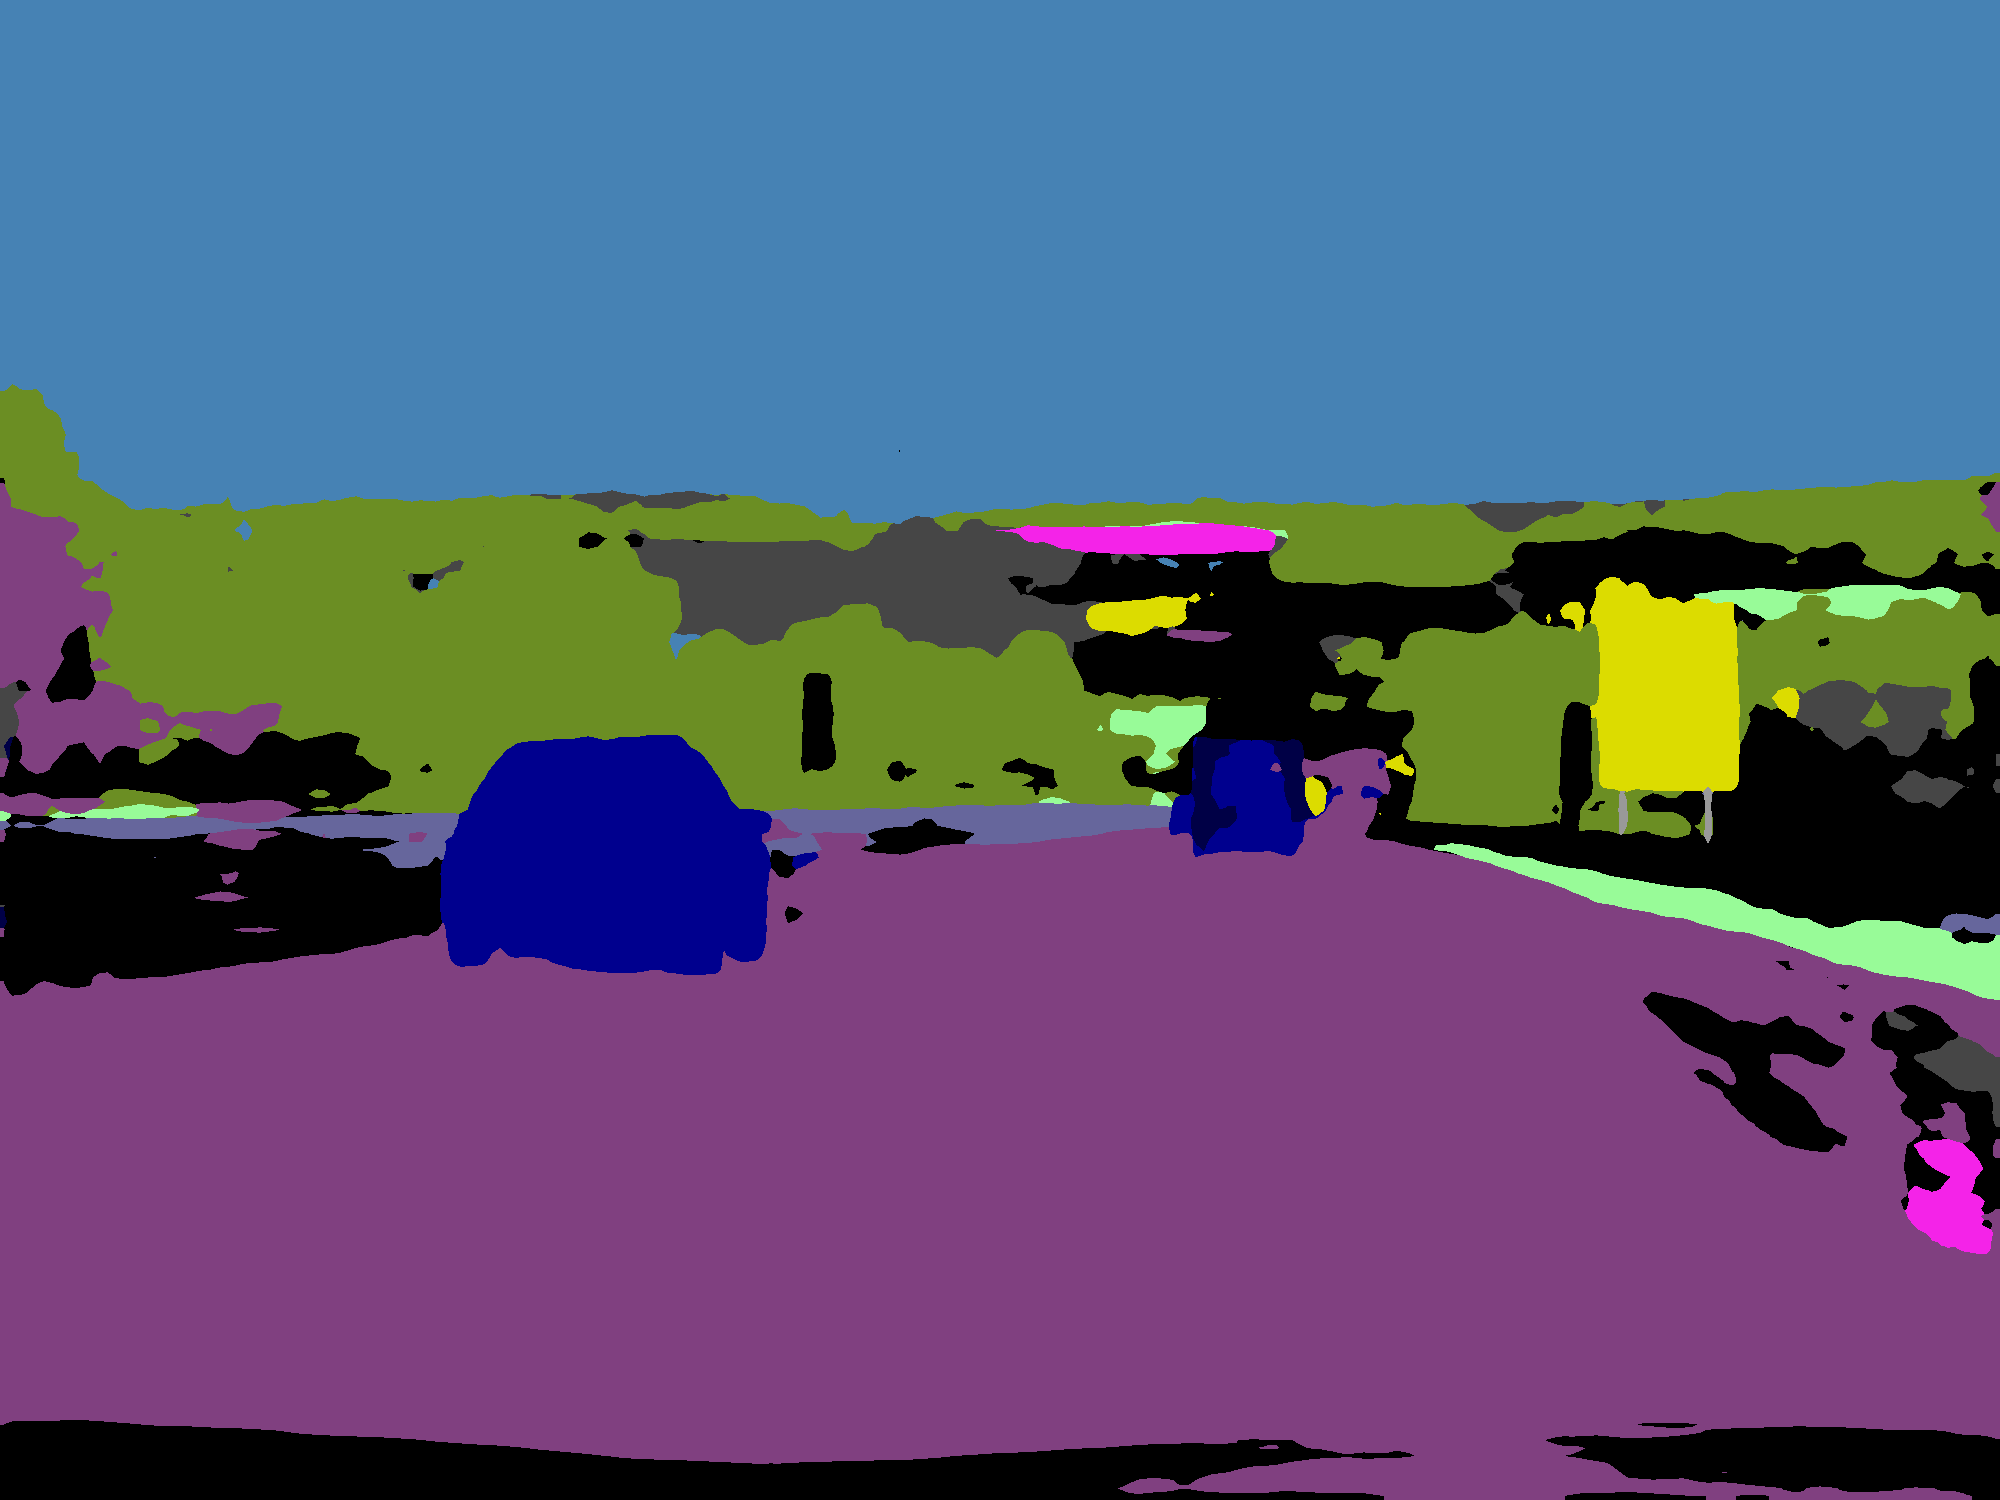

In [ ]:
from mask_generation import generate_segmentation_mask_file

generate_segmentation_mask_file(
    device=device,
    checkpoint_path=".\\model\\resnet50_cityscapes.ckpt",
    input_img_path=".\\test\\test2.png",
    classes=Cityscapes.classes
)